In [1]:
from pathlib import Path
from operator import itemgetter, add
from itertools import product, chain, cycle, zip_longest
from functools import reduce

import requests

import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
get_cases = itemgetter('cases')
get_cured = itemgetter('cured')
get_deaths = itemgetter('deaths')
get_value = itemgetter('v')

def concat_cols(data):
    return (data[0],) + data[1]

def parse_region_data(data):
    region = data['info']['name']

    if isinstance(get_cases(data)[0], dict):
        counts = zip_longest(map(get_value, get_cases(data)),
                             map(get_value, get_cured(data)),
                             map(get_value, get_deaths(data)), fillvalue=0)
    else:
        counts = zip_longest(get_cases(data),
                             get_cured(data),
                             get_deaths(data), fillvalue=0)
        
    parsed_data = product([region], counts)
    parsed_data = map(concat_cols, parsed_data)
    parsed_data = parsed_data
    
    return parsed_data

def parse_russian_data(data):
    russian_data = data['russia_stat_struct']
    
    dates = russian_data['dates']
    region_data = russian_data['data'].values()
    
    data_size = len(region_data)
    all_dates = cycle(dates)
    
    parsed_data = map(parse_region_data, region_data)
    parsed_data = chain.from_iterable(parsed_data)
    
    parsed_data = zip(all_dates, parsed_data)
    parsed_data = map(concat_cols, parsed_data)
    
    return parsed_data

def combine_results(acc, nxt):
    key = nxt[0]
    values = nxt[1]
    
    result = product([key], values)
    result = map(concat_cols, result)
    
    return acc | set(result)

def download_file(url):
    r = requests.get(url)
    r.raise_for_status()

    data = r.json()
    
    return data

def combine_data(results):
    full_results = reduce(combine_results, results.items(), set())
    full_results = sorted(full_results, key=itemgetter(0, 1, 2))
    
    return full_results

def calculate_stats(data):
    columns=['file_num', 'date', 'region', 'infected', 'recovered', 'dead']
    
    stats_df = pd.DataFrame.from_records(data, columns=columns, index='file_num')
    stats_df = stats_df[stats_df['region'] != 'Россия']
    stats_df = stats_df.groupby(['date', 'region'], as_index=False).last()
    
    return stats_df 

def save_data(df, file_path):
    df.to_csv(file_path, index=False)

def gather_russian_stats(file_path, history_type='standard'):
    history_types = {
        'standard':'https://yastat.net/s3/milab/2020/covid19-stat/data/data_struct_{num}.json?v=timestamp',
        'deep': 'https://yastat.net/s3/milab/2020/covid19-stat/data/deep_history_struct_{num}.json?v=1591117446'
    }
    
    url_template = history_types[history_type]

    i = 1
    results = {}

    while True:
        print(str(i))

        url = url_template.format(num=i)
        try:
            data = download_file(url)
        except requests.exceptions.HTTPError as err:
            print(err)
            break

        try:
            results[i] = tuple(parse_russian_data(data))
        except KeyError as err:
            print('Russian data is not found', err)

        i += 1
    
    full_results = combine_data(results)
    stats_df = calculate_stats(full_results)
    save_data(stats_df, file_path)
    
    return stats_df

In [ ]:
file_path = Path('../data/russian_stats.csv')
stats_df = gather_russian_stats(file_path, history_type='deep')

[]

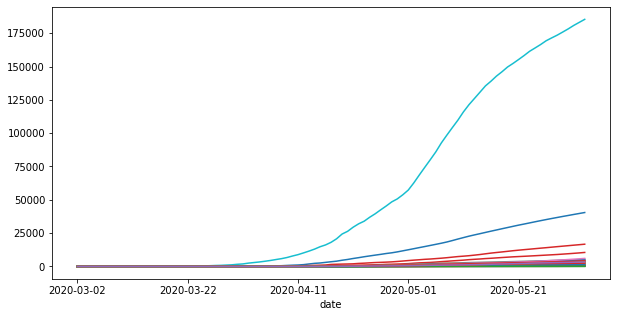

In [5]:
fig, axes = plt.subplots(figsize=(10, 5))
stats_df.set_index('date').groupby('region')['infected'].plot(ax=axes)
plt.plot()